In [1]:
using NCDatasets
using Statistics
using Dates
using PyPlot
push!(LOAD_PATH, "../julia/")
using SST
using DINEOFtools
using DIVAnd

## Files and directories

In [2]:
datamonthdir = "/data/SST/Global/monthly/"
dataclimdir = "/data/SST/Global/monthly_clim/"
outputdir = "/data/SST/Global/DINEOF/"

"/data/SST/Global/DINEOF/"

Create lists of files

In [3]:
sst_month_list = SST.get_sst_file_list(datamonthdir);
sst_clim_list = SST.get_sst_file_list(dataclimdir);

┌ Info: Found 245 files
└ @ SST /home/ctroupin/Projects/FNRS-UpwellingFilaments/Filament-Submesoscale/julia/SST.jl:26
┌ Info: Found 12 files
└ @ SST /home/ctroupin/Projects/FNRS-UpwellingFilaments/Filament-Submesoscale/julia/SST.jl:26


## Main loop 

In [4]:
sat = "TERRA"
sensor = "MODIS"
domain = [-40, 0., 10., 50.]
valex = -999.

lon, lat, sst = SST.read_sst_oceancolor_L3(sst_month_list[1], domain)
nlon = length(lon)
nlat = length(lat)

# Allocation
ntimes = length(sst_month_list[2:end])
sstanom = Array{Float64, 3}(undef, nlon, nlat, ntimes);
times = Vector{Float32}(undef, ntimes);

In [5]:
for (ii, datafiles) in enumerate(sst_month_list[2:10])
    @info("Working on file $(basename(datafiles))")
    
    year, month = SST.get_year_month_file(datafiles)

    # According to the month, the monthly climatology covers a different period
    month == 1 ? yearstart = 2001 : yearstart = 2000
    month <= 5 ? yearend = 2020 : yearend = 2019
    sstclimfile = SST.get_monthly_clim_filename(sat, sensor, yearstart, yearend, month; res="9km")
    
    if (isfile(joinpath(dataclimdir, sstclimfile)))
        
        # Read climatological field
        lon, lat, sstclim = SST.read_sst_oceancolor_L3(joinpath(dataclimdir, sstclimfile), domain);
        # Read SST
        _, _, sst = SST.read_sst_oceancolor_L3(datafiles, domain)
        
        # Compute anomalies
        sst_anom = sst .- sstclim;
        sst_anom[isnan.(sst_anom)] .= valex;
        sstanom[:,:,ii] = sst_anom;

        # Extract date
        times[ii] = (Dates.Date(year, month) - Dates.Date(1981, 1, 1)).value
        
    else
        @error("File does not exist")
    end
end

┌ Info: Working on file TERRA_MODIS.20000301_20000331.L3m.MO.SST4.sst4.9km.nc
└ @ Main In[5]:2
┌ Info: Working on file TERRA_MODIS.20000401_20000430.L3m.MO.SST4.sst4.9km.nc
└ @ Main In[5]:2
┌ Info: Working on file TERRA_MODIS.20000501_20000531.L3m.MO.SST4.sst4.9km.nc
└ @ Main In[5]:2
┌ Info: Working on file TERRA_MODIS.20000601_20000630.L3m.MO.SST4.sst4.9km.nc
└ @ Main In[5]:2
┌ Info: Working on file TERRA_MODIS.20000701_20000731.L3m.MO.SST4.sst4.9km.nc
└ @ Main In[5]:2
┌ Info: Working on file TERRA_MODIS.20000801_20000831.L3m.MO.SST4.sst4.9km.nc
└ @ Main In[5]:2
┌ Info: Working on file TERRA_MODIS.20000901_20000930.L3m.MO.SST4.sst4.9km.nc
└ @ Main In[5]:2
┌ Info: Working on file TERRA_MODIS.20001001_20001031.L3m.MO.SST4.sst4.9km.nc
└ @ Main In[5]:2
┌ Info: Working on file TERRA_MODIS.20001101_20001130.L3m.MO.SST4.sst4.9km.nc
└ @ Main In[5]:2


### Create land-sea mask

In [6]:
mask, ngood = DINEOFtools.compute_mask(sstanom; threshold=0.03, valex=valex)

([1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0], [0.9959016393442623 1.0 … 1.0 1.0; 0.9959016393442623 0.9959016393442623 … 1.0 1.0; … ; 1.0 1.0 … 0.9631147540983607 0.9631147540983607; 1.0 1.0 … 0.9631147540983607 0.9631147540983607])

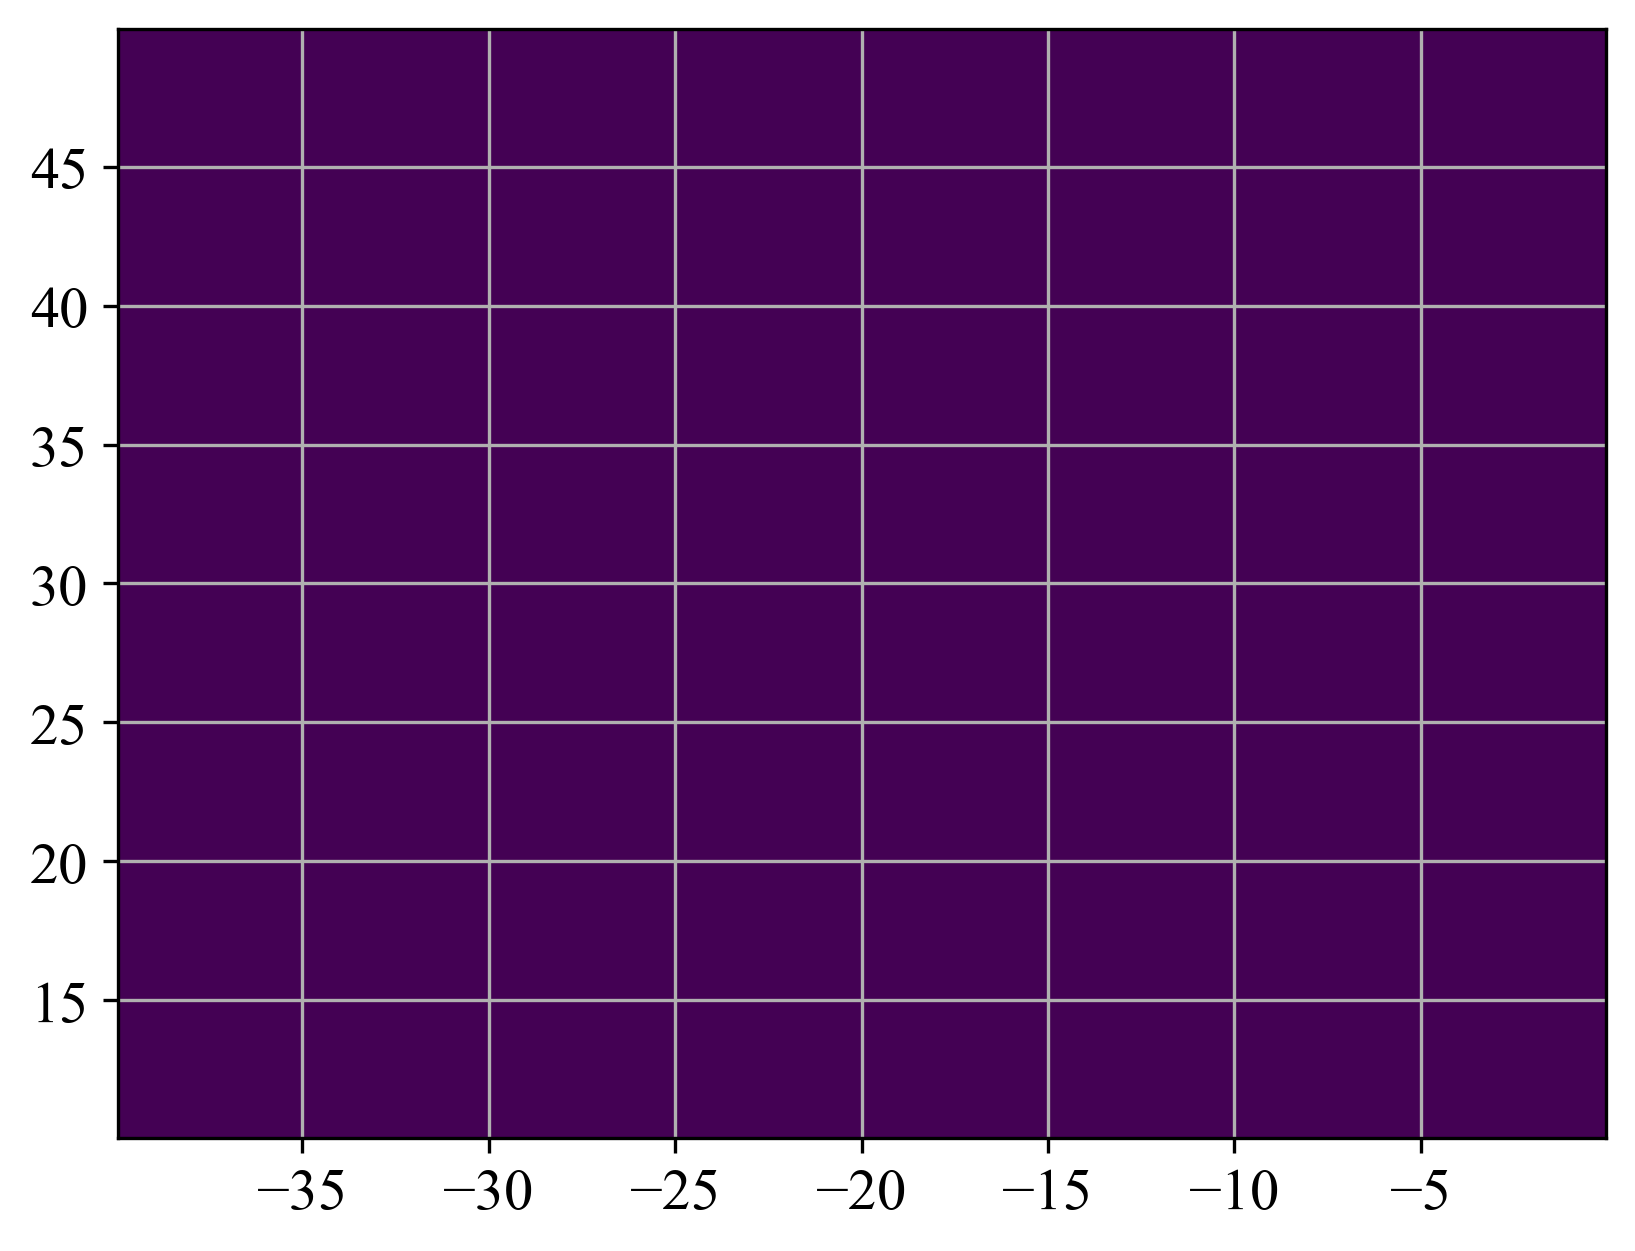

In [7]:
pcolor(lon, lat, mask')
PyPlot.grid()
show()

We need to process the mask to remove lakes.

In [22]:
mask2 = copy(mask);
sel2 = ((lat .>= 37.5) .& (lat .<= 39.)) 
sel1 = (lon .>= -8.2)
mask2[sel1, sel2] .= 0.;
#sel1 = lon .>= -6.25
#sel2 = lat .>= 36.55
#mask2[sel1, sel2] .= 0.;

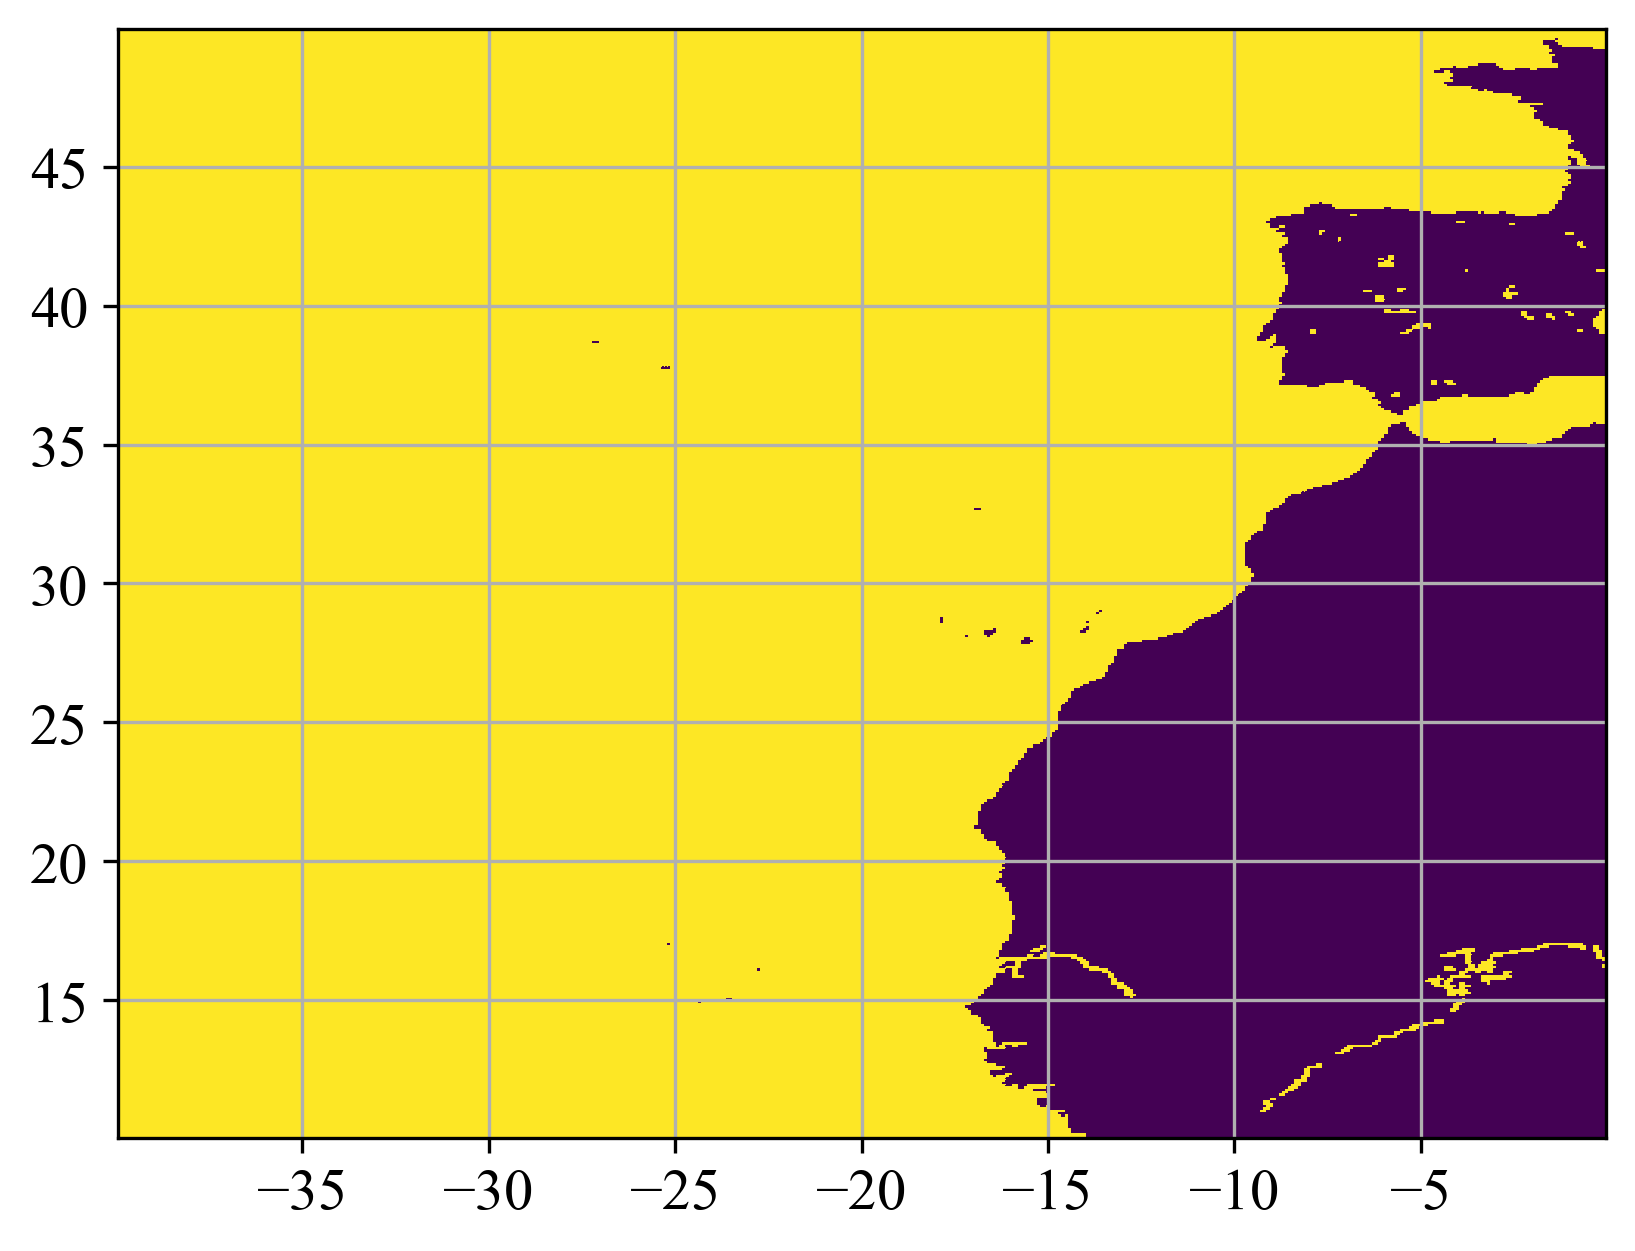

In [23]:
pcolor(lon, lat, mask2')
PyPlot.grid()
show()

We will use the GEBCO bathymetry to also mask islands (to be done later... not direct).

In [10]:
SST.create_sst_file(joinpath(outputdir, "NEAtlantic_sst2.nc"), lon, lat, times, sstanom, mask2; valex=valex);